# Taxi Q-Learning
**Made by:**
- Angelo Trifelli, 1920939

# Problem Description

The Taxi problem involves navigating in a 5x5 grid world, which contains <b>four</b> special locations designated as pick-up and drop-off locations (they're identified with the colors <i>Red, Green, Yellow</i> and <i>Blue</i>). The goal of the Taxi is to pick-up the passenger and drop him off at one of the four designated locations

## Action Space
The action space is discrete and composed by <b>6</b> deterministic actions. Every action is identified by a corresponding integer number.

- 0: Move south (down)
- 1: Move north (up)
- 2: Move east (right)
- 3: Move west (left)
- 4: Pickup passenger
- 5: Drop off passenger

## Observation Space
Since there are <b>25</b> taxi positions, <b>5</b> possible locations of the passenger (including the case when the passenger is in the taxi) and <b>4</b> destination locations we have in total <b>500</b> discrete states.

## Rewards
We have three possible rewards that we can receive:
- -1 : default reward; returned when a step is performed (expect when another reward is triggered).
- +20: delivering the passenger
- -10: executing "pickup" or "drop-off" actions illegally.

We must precise that the environment offers by default only <b>200</b> steps and the episode will end not only when the taxi drops off the passenger, but also when the maximum number of steps is reached.

## Starting State
The Taxi starts off at a random square and the passenger at one of the designated special locations. The destination location is also randomly chosen among the remaining three special locations.


# Solutions
In order to solve this environment, two types of solutions have been used: Tabular Q-Learning and Deep Q-Learning

## Tabular Q-Learning
With Tabular Q-Learning the core idea is to estimate the so called <b>Q-Values</b>, which represent the <i>expected utility</i> of taking a certain action in a given state. All the Q-Values are stored in a <b>Q-Table</b>: a matrix where each entry corresponds to a specific state-action pair <i>(s, a)</i>

The update rule is based on the <b>Bellman Equation</b>
<br />
<br />
$$
Q(s, a) = r(s,a) + \gamma \max_{a'\in A} Q(s', a')
$$

In particular, the solution that has been implemented will follow an <i>$ϵ$-greedy</i> strategy

In our case, since we have <b>500</b> reachable states and <b>6</b> possible actions, the Q-Table will have a dimension of <i>500 x 6 = 3000</i>

## Deep Q-Learning
The basic idea of <b>Deep Q-Learning</b> (<b>DQN</b>) is to remove the need to store the Q-Values into a table but instead combine the Q-Learning algorithm with an <b>artificial neural network</b>.
- Input: current state of the environment
- Output: Q-Values for each executable action

We will keep using the same strategy for the action selection and the formula that will be used to update the Q-Values remains the same

<b>Experience memory</b>: data structure used as the main datasource for the network training
<br />
<br />
$$
(state, action, reward, next\_state, done)
$$

We will now see three different solutions that has been implemented with the usage of a DQN:

# Implementation

## Dependencies

In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.4 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

from pathlib import Path
from collections import deque
from types import SimpleNamespace
from tqdm import trange
from tqdm import tqdm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hyperparameters


In [4]:
tabular_q_learning_props = SimpleNamespace(
    learning_rate = 0.1,
    discount_factor = 0.99,
    exploration_rate = 1.0,
    exploration_rate_decay = 400,
    minimum_exploration_rate = 0.01,
    num_episodes = 3000,
    max_steps_per_episode = 200
)

deep_q_network_props = SimpleNamespace(
    network = SimpleNamespace(
        initial_lr = 0.001,
        minimum_lr = 0.0001,
        lr_decay = 5000,
        batch_size = 128
    ),
    env = SimpleNamespace(
        num_episodes = 7000,
        max_steps_per_episode = 100
    ),
    rl = SimpleNamespace(
        discount_factor = 0.99,
        exploration_rate = 1,
        minimum_exploration_rate = 0.1,
        exploration_rate_decay = 400,
        memory_size = 5000,
        train_start = 1000,
        target_network_update_freq = 20
    )
)

## Tabular Q-Learning

### Variables Setup

In [8]:
env = gym.make('Taxi-v3')

#Initialize Q-Table. It will be a table with dimension 500 x 6
q_table = np.zeros((env.observation_space.n, env.action_space.n))

#Get configuration parameters
num_episodes = tabular_q_learning_props.num_episodes
max_steps = tabular_q_learning_props.max_steps_per_episode
alpha = tabular_q_learning_props.learning_rate
gamma = tabular_q_learning_props.discount_factor
epsilon = tabular_q_learning_props.exploration_rate
epsilon_min = tabular_q_learning_props.minimum_exploration_rate
epsilon_decay = tabular_q_learning_props.exploration_rate_decay

success_list = []
total_rewards_list = []

### Training

In [ ]:
for episode in tqdm(range(num_episodes), desc="Executing"):
    state, info = env.reset()   #Start the environment and obtain the initial state
    completed = False
    current_step = 0
    total_reward = 0

    while not completed and current_step < max_steps:
        action_mask = info.get('action_mask')
        valid_actions = np.where(action_mask == 1)[0]

        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(valid_actions)  #Exploration: pick a random action
        else:
            q_values_valid_actions = q_table[state, valid_actions]
            action = valid_actions[np.argmax(q_values_valid_actions)]  #Exploitation: choose the action with the highest Q-Value

        next_state, reward, done, truncated, new_info = env.step(action)     #Execute the action
        total_reward += reward

        #Update the Q-Value
        best_next_action = np.argmax(q_table[next_state, :])
        q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * q_table[next_state, best_next_action] - q_table[state, action])

        state = next_state
        info = new_info
        current_step += 1

        if done or truncated:
            if not truncated:
                success_list.append(episode)
            completed = True

    epsilon = epsilon_min + (tabular_q_learning_props.exploration_rate - epsilon_min) * np.exp(-episode / epsilon_decay)
    total_rewards_list.append(total_reward)


print(f"Total number of successfull episodes: {len(success_list)}")

env.close()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
plt.title("Training result")

ax1.set_xlabel('Episode')
ax1.set_ylabel('Rewards')
ax1.set_ylim(-230, 250)
ax1.set_title("Rewards")
ax1.plot(total_rewards_list, color="red")

plt.show()

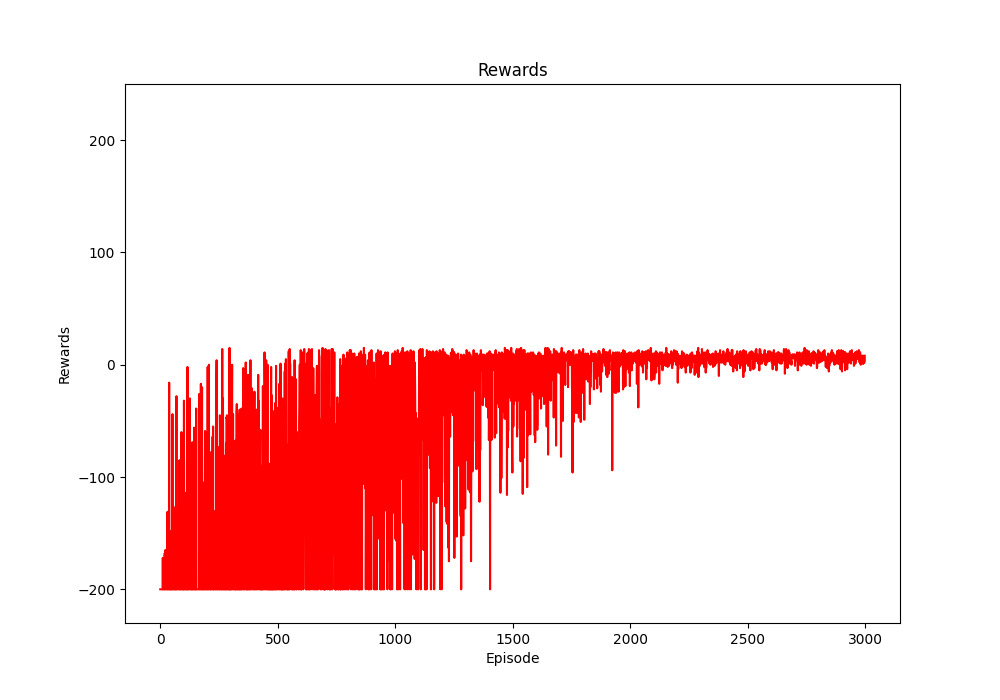

### Evaluating

In [ ]:
new_env = gym.make('Taxi-v3')

for episode in range(10):
    print(f"Episode number: {episode + 1}")
    state, info = new_env.reset()

    for _ in tqdm(range(200)):
        action_mask = info.get('action_mask')
        valid_actions = np.where(action_mask == 1)[0]

        q_values_valid_actions = q_table[state, valid_actions]
        action = valid_actions[np.argmax(q_values_valid_actions)]

        next_state, reward, terminated, truncated, new_info = new_env.step(action)

        state = next_state
        info = new_info

        if terminated or truncated:
            if truncated:
                print(f"Insuccess for episode {episode + 1}")
            else:
                print(f"Success for episode {episode + 1}")

            break

new_env.close()

## Deep Q-Learning - First Solution

### Model definition

In [10]:
class RLModel(nn.Module):

    def __init__(self, input_size, output_size):
        super(RLModel, self).__init__()

        self.embedding = nn.Embedding(input_size, 4)
        self.fc1 = nn.Linear(4, 25)
        self.fc2 = nn.Linear(25, 25)
        self.output = nn.Linear(25, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.output(x)
        return x

### Functions

In [11]:
def choose_action(model, state: int, exploration_rate: float):
    if np.random.uniform(0, 1) < exploration_rate:
        return env.action_space.sample()        # Exploration: pick a random action

    with torch.no_grad():
        q_values = model(torch.tensor([state], device=torch.device('cpu')))     #Exploitation: pick the action with the highest q_value
        return q_values.max(1)[1].item()

def train_model(model, optimizer, loss_fn, memory):
    if len(memory) < deep_q_network_props.network.batch_size:
        return

    batch = random.sample(memory, deep_q_network_props.network.batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    state_batch = torch.tensor(states, device=torch.device('cpu'))
    action_batch = torch.tensor(actions, device=torch.device('cpu'), dtype=torch.long)
    reward_batch = torch.tensor(rewards, device=torch.device('cpu'))
    next_state_batch = torch.tensor(next_states, device=torch.device('cpu'))
    done_batch = torch.tensor(dones, device=torch.device('cpu'), dtype=torch.bool)

    # Compute current q_values prediction
    current_q_values = model(state_batch).gather(1, action_batch.unsqueeze(1))

    # Compute expected q_values that the network should predict
    expected_q_values = reward_batch + (torch.logical_not(done_batch) * deep_q_network_props.rl.discount_factor * model(next_state_batch).max(1)[0])

    loss = loss_fn(current_q_values, expected_q_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()


def plot_chart(total_reward_list, epsilon_list):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    plt.subplots_adjust(wspace=0.5)

    plt.title("Training result")

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Rewards')
    ax1.set_ylim(-1000, 250)
    ax1.set_title("Rewards")
    ax1.plot(total_reward_list, color="red")

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Epsilon')
    ax2.set_title('Epsilon decay')
    ax2.plot(epsilon_list, color="C2")

    plt.show()

### Variables Setup

In [13]:
env = gym.make('Taxi-v3')
state_size = env.observation_space.n        # 500 states
action_size = env.action_space.n            # 6 actions

model = RLModel(state_size, action_size).to(torch.device('cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=deep_q_network_props.network.initial_lr)
loss_fn = torch.nn.functional.smooth_l1_loss

memory = deque(maxlen=deep_q_network_props.rl.memory_size)
epsilon = deep_q_network_props.rl.exploration_rate
minimum_epsilon = deep_q_network_props.rl.minimum_exploration_rate
epsilon_decay = deep_q_network_props.rl.exploration_rate_decay

total_reward_list = []
epsilon_list = []
successful_episodes = []

### Training

In [ ]:
progress_bar = trange(0, deep_q_network_props.env.num_episodes)

for episode in progress_bar:
    state, _ = env.reset()
    total_reward = 0

    if len(memory) >= deep_q_network_props.rl.train_start:
        epsilon = minimum_epsilon + (deep_q_network_props.rl.exploration_rate - minimum_epsilon) * np.exp(-episode / epsilon_decay)

    for current_step in range(0, 200):
        action = choose_action(model, state, epsilon)

        next_state, reward, done, truncated, _ = env.step(action)

        if len(memory) > deep_q_network_props.rl.memory_size:
            memory.popleft()

        memory.append([*[state, action, reward, next_state, done]])

        if len(memory) >= deep_q_network_props.rl.train_start:
            train_model(model, optimizer, loss_fn, memory)

        state = next_state
        total_reward += reward

        if done or truncated:
            if not truncated:
                successful_episodes.append(episode)

            total_reward_list.append(total_reward)
            epsilon_list.append(epsilon)

            progress_bar.set_postfix({
                "reward": total_reward,
                "epsilon": epsilon
            })
            break

plot_chart(total_reward_list, epsilon_list)
print(f"Total number of successful episodes: {len(successful_episodes)}")
torch.save(model.state_dict(), './models/DQN-V1.pth')

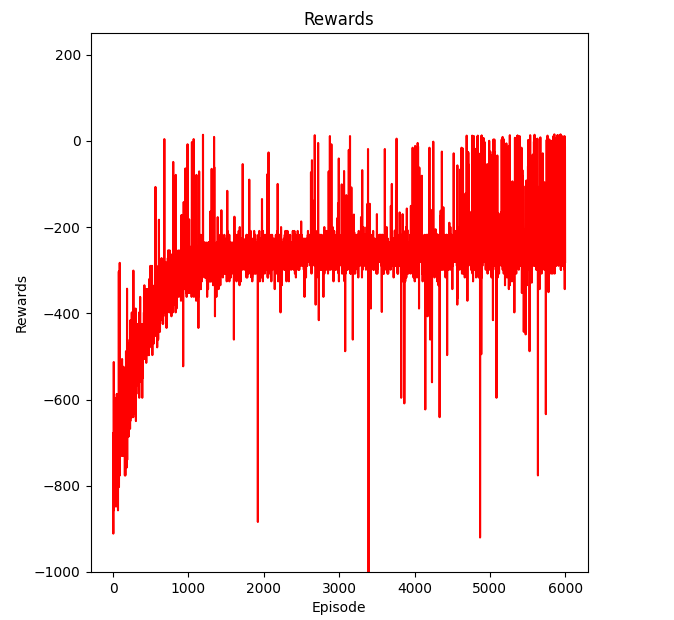

### Evaluation

In [15]:
model = RLModel(state_size, action_size).to(torch.device('cpu'))

model_path = '/content/drive/MyDrive/Colab Notebooks/ML-Project/models/DQN-V1.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

<ipython-input-15-7aa78e25a71f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


RLModel(
  (embedding): Embedding(500, 4)
  (fc1): Linear(in_features=4, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=25, bias=True)
  (output): Linear(in_features=25, out_features=6, bias=True)
)

In [ ]:
def choose_action(model, state, info):
    action_mask = info.get('action_mask')

    with torch.no_grad():
        if np.random.uniform(0, 1) < 0.3:
            valid_actions = np.where(action_mask == 1)[0]
            return np.random.choice(valid_actions)
        else:
            predicted = model(torch.tensor([state], device=torch.device('cpu')))
            q_values = predicted.cpu().numpy()[0]
            q_values[action_mask == 0] = -float('inf')
            action = q_values.argmax()
            return action

env = gym.make("Taxi-v3")
state_size = env.observation_space.n
action_size = env.action_space.n

for episode in range(10):
    print(f"Episode number: {episode + 1}")
    state, info = env.reset()
    total_reward = 0

    progress_bar = trange(0, 200, initial=0, total=200)

    for _ in progress_bar:
        action = choose_action(model, state, info)

        print(f"Selected action: {action}")

        next_state, reward, done, truncated, new_info = env.step(action)
        total_reward += reward

        state = next_state
        info = new_info

        if done or truncated:
            print(f"Total reward {total_reward}")
            if truncated:
                print(f"Insuccess for episode {episode + 1}")
            else:
                print(f"Success for episode {episode + 1}")

            break

env.close()

## Deep Q-Learning - Second solution

### Model Definition

In [ ]:
class RLModel(nn.Module):

    def __init__(self, input_size, output_size):
        super(RLModel, self).__init__()

        self.emb = nn.Embedding(input_size, 4)
        self.l1 = nn.Linear(4, 50)
        self.l2 = nn.Linear(50, 50)
        self.l3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = self.emb(x)
        x = nn.functional.relu(self.l1(x))
        x = nn.functional.relu(self.l2(x))
        x = self.l3(x)
        return x

###  Functions

In [ ]:
def choose_action(model, state: int, exploration_rate: float):
    if np.random.uniform(0, 1) < exploration_rate:
        action = env.action_space.sample()        # Exploration: pick a random action
    else:
        with torch.no_grad():
            q_values = model(torch.tensor([state], device=torch.device('cpu')))     #Exploitation: pick the action with the highest q_value
            action = q_values.max(1)[1].item()

    return action

def train_model(model, target_model, optimizer, loss_fn, memory):
    if len(memory) < deep_q_network_props.network.batch_size:
        return

    batch = random.sample(memory, deep_q_network_props.network.batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    state_batch = torch.tensor(states, device=torch.device('cpu'))
    action_batch = torch.tensor(actions, device=torch.device('cpu'), dtype=torch.long)
    reward_batch = torch.tensor(rewards, device=torch.device('cpu'))
    next_state_batch = torch.tensor(next_states, device=torch.device('cpu'))
    done_batch = torch.tensor(dones, device=torch.device('cpu'), dtype=torch.bool)

     # Compute predicted Q values
    predicted_q_value = model(state_batch).gather(1, action_batch.unsqueeze(1))

    # Use Bellman equation to compute new expected values
    expected_q_values = reward_batch + (torch.logical_not(done_batch) * target_model(next_state_batch).max(1)[0] * 0.99)

    # Compute loss
    loss = loss_fn(predicted_q_value, expected_q_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def decay_learning_rate(optimizer, episode):
  minimum_lr = deep_q_network_props.network.minimum_lr
  new_lr = minimum_lr + (deep_q_network_props.network.initial_lr - minimum_lr) * np.exp(- episode / deep_q_network_props.network.lr_decay)
  for elem in optimizer.param_groups:
      elem['lr'] = new_lr

### Variables Setup

In [ ]:
env = gym.make('Taxi-v3')
state_size = env.observation_space.n        # 500 states
action_size = env.action_space.n            # 6 actions

model = RLModel(state_size, action_size).to(torch.device('cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=deep_q_network_props.network.initial_lr)
loss_fn = torch.nn.functional.smooth_l1_loss

target_model = RLModel(state_size, action_size).to(torch.device('cpu'))
target_model.load_state_dict(model.state_dict())
target_model.eval()


memory = deque(maxlen=deep_q_network_props.rl.memory_size)
epsilon = deep_q_network_props.rl.exploration_rate
minimum_epsilon = deep_q_network_props.rl.minimum_exploration_rate
epsilon_decay = deep_q_network_props.rl.exploration_rate_decay

total_reward_list = []
epsilon_list = []

### Training

In [ ]:
progress_bar = trange(0, deep_q_network_props.env.num_episodes)
successful_episodes = []


for episode in progress_bar:
    state, _ = env.reset()
    total_reward = 0

    if len(memory) >= deep_q_network_props.rl.train_start:
        epsilon = minimum_epsilon + (deep_q_network_props.rl.exploration_rate - minimum_epsilon) * np.exp(-episode / epsilon_decay)

    for current_step in range(0, deep_q_network_props.env.max_steps_per_episode):
        action = choose_action(model, state, epsilon)

        next_state, reward, done, truncated, _ = env.step(action)

        if len(memory) > deep_q_network_props.rl.memory_size:
            memory.popleft()

        memory.append([*[state, action, reward, next_state, done]])

        if len(memory) >= deep_q_network_props.rl.train_start:
            train_model(model, target_model, optimizer, loss_fn, memory)
            decay_learning_rate(optimizer, episode)

        state = next_state
        total_reward += reward

        if done and not truncated:
            successful_episodes.append(episode)

        done = done or (current_step == deep_q_network_props.env.max_steps_per_episode - 1)

        if done or truncated:
            total_reward_list.append(total_reward)
            epsilon_list.append(epsilon)

            progress_bar.set_postfix({
                "reward": total_reward,
                "epsilon": epsilon
            })
            break

    if episode % deep_q_network_props.rl.target_network_update_freq == 0:
        target_model.load_state_dict(model.state_dict())



plot_chart(total_reward_list, epsilon_list)
print(f"Total number of successful episodes: {len(successful_episodes)}")
torch.save(model.state_dict(), './models/DQN-V2.pth')

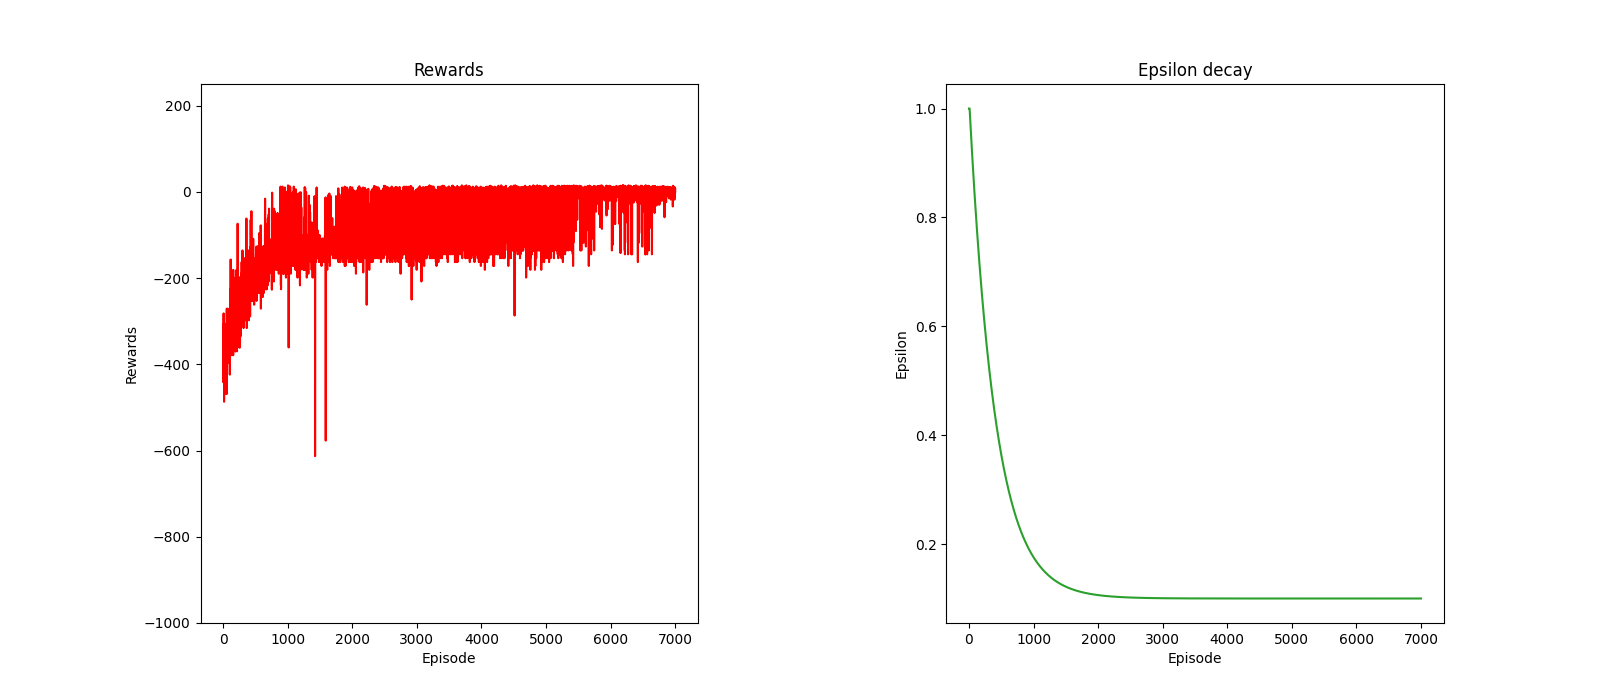

### Evaluation

In [ ]:
def choose_action(model, state, info):
    action_mask = info.get('action_mask')

    with torch.no_grad():
        predicted = model(torch.tensor([state], device=torch.device('cpu')))
        q_values = predicted.cpu().numpy()[0]
        q_values[action_mask == 0] = -float('inf')
        action = q_values.argmax()
        return action

In [ ]:
env = gym.make("Taxi-v3", render_mode='human')
state_size = env.observation_space.n
action_size = env.action_space.n

model = RLModel(state_size, action_size).to(torch.device('cpu'))
model.load_state_dict(torch.load(model_path = '/content/drive/MyDrive/Colab Notebooks/ML-Project/models/DQN-V2.pth'))
model.eval()

In [ ]:
for episode in range(10):
    print(f"Episode number: {episode + 1}")
    state, info = env.reset()
    total_reward = 0

    progress_bar = trange(0, 200, initial=0, total=200)

    for _ in progress_bar:
        action = choose_action(model, state, info)

        print(f"Selected action: {action}")

        next_state, reward, done, truncated, new_info = env.step(action)
        total_reward += reward

        state = next_state
        info = new_info

        if done or truncated:
            print(f"Total reward {total_reward}")
            if truncated:
                print(f"Insuccess for episode {episode + 1}")
            else:
                print(f"Success for episode {episode + 1}")

            break

env.close()